In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Installations and imports**

In [2]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [3]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import deepchem as dc
import plotly.express as px
from deepchem.molnet import load_tox21
from rdkit.Chem import PandasTools
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Descriptors import MaxPartialCharge
from rdkit.Chem.Descriptors import MinPartialCharge
from rdkit.Chem.rdMolDescriptors import CalcFractionCSP3
from rdkit.Chem.rdMolDescriptors import CalcNumAliphaticRings
from rdkit.Chem.rdMolDescriptors import CalcNumAmideBonds
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticRings
from rdkit.Chem.rdMolDescriptors import CalcNumHBD
from rdkit.Chem.rdMolDescriptors import CalcNumHBA
from rdkit.Chem.rdMolDescriptors import CalcNumHeteroatoms
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Descriptors import qed
from rdkit.Chem import MolFromSmiles
import matplotlib.pyplot as plt


# **Custom function to add calculated properties to dataframe**

In [4]:
def add_props_to_df(df, molCol):
  prop_functions = [MolLogP, MolWt, MaxPartialCharge, MinPartialCharge, CalcFractionCSP3, CalcNumAliphaticRings,
                    CalcNumAmideBonds, CalcNumAromaticRings, CalcNumHBD, CalcNumHBA, CalcNumHeteroatoms,
                    CalcNumRotatableBonds, CalcTPSA, qed]
  prop_names = ["MolLogP", "MolWt", "MaxPartialCharge", "MinPartialCharge", "CalcFractionCSP3", "CalcNumAliphaticRings",
                    "CalcNumAmideBonds", "CalcNumAromaticRings", "CalcNumHBD", "CalcNumHBA", "CalcNumHeteroatoms",
                    "CalcNumRotatableBonds", "CalcTPSA", "qed"]
  for idx, f in enumerate(prop_functions):
    df[prop_names[idx]] = df[molCol].apply(f)


def plot_prop_dists(data, prop_names = ["MolLogP", "MolWt", "MaxPartialCharge", "MinPartialCharge", "CalcFractionCSP3", "CalcNumAliphaticRings",
                                        "CalcNumAmideBonds", "CalcNumAromaticRings", "CalcNumHBD", "CalcNumHBA", "CalcNumHeteroatoms",
                                        "CalcNumRotatableBonds", "CalcTPSA", "qed"]):
  for i, prop in enumerate(prop_names):
    plt.figure(i)
    sns.displot(data=data, x=prop)
    plt.axvline(x=data[prop].median(), color="blue", ls="--",lw=2)
    plt.text(data[prop].median()+(data[prop].median()-data[prop].min())/5, 300, str(data[prop].median()))

## **Load Tox21 data**

In [5]:

tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(random_state=42)

[04:27:00] WARNING: not removing hydrogen atom without neighbors
[04:27:18] WARNING: not removing hydrogen atom without neighbors


In [6]:
train_dataset, valid_dataset, test_dataset = tox21_datasets

## **Extract relevant data to dataframe and reformat**

In [7]:
train_df = pd.DataFrame(train_dataset.y, columns = tox21_tasks)
train_df['SMILES'] = train_dataset.ids
train_df_melt = train_df.melt('SMILES', var_name='tox_class', value_name='value')
train_df_melt = train_df_melt.fillna('NaN input')

In [8]:
train_df_counts = train_df_melt.groupby(by=['tox_class', 'value'])['SMILES'].count()

In [9]:
train_df_counts = train_df_counts.reset_index()
train_df_counts['value'] = train_df_counts['value'].map({0:'Non-toxic',1:'Toxic'})

## **Generate plot of Tox21 training data distribution**

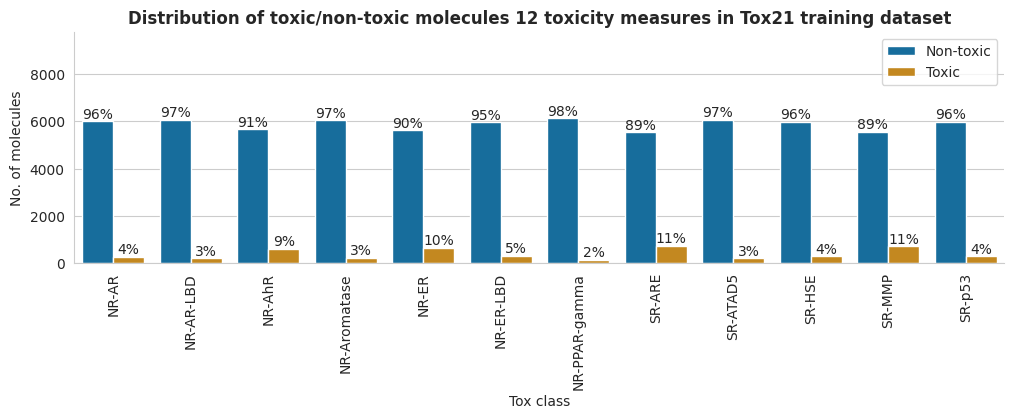

In [10]:
def get_bar_percent(x):
  return '{0:.0%}'.format(x/6264)
sns.set_style('whitegrid')
plt.figure(figsize=(12,3))
g = sns.barplot(data=train_df_counts.reset_index(), 
            x='tox_class', y='SMILES',hue='value',
            palette=sns.color_palette('colorblind'))
g.legend_.set_title(None)
plt.title('Distribution of toxic/non-toxic molecules 12 toxicity measures in Tox21 training dataset', weight='bold')#.set(title='Distribution of toxic and non-toxic molecules for each of 12 toxicity measures', weight='bold')
g.set_ylim(0,9800)
plt.xticks(rotation=90)
plt.xlabel('Tox class')
plt.ylabel('No. of molecules')
sns.despine()
for i in g.containers:
  g.bar_label(i,fmt=get_bar_percent)
plt.show()

# Load ChEMBL HepG2 data

In [11]:
hepg2_df = pd.read_csv('./gdrive/MyDrive/hepg2_output_df.csv')

In [12]:
hepg2_df['pCC50'] = -np.log10(hepg2_df['IC50']*1e-9)

In [13]:
hepg2_df['tox_class'] = hepg2_df['pCC50'].apply(lambda x: 'Non-toxic' if x <= 5 else 'Toxic')

In [14]:
hepg2_df.head()

,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pCC50,tox_class
0,0,CHEMBL1315471,35481.3,nM,CCN(CC(=O)NCc1cccs1)S(=O)(=O)c1cc(NC(C)=O)ccc1OC,4.450000,Non-toxic
1,1,CHEMBL1511566,2818.4,nM,O=C(CN(c1ccc(F)cc1)S(=O)(=O)c1ccc2c(c1)OCCO2)N...,5.549997,Toxic
2,2,CHEMBL1904108,35481.3,nM,O=C(CCN1C(=O)/C(=C\c2ccccc2F)SC1=S)N1CCOCC1,4.450000,Non-toxic
3,3,CHEMBL1369478,35481.3,nM,COc1cc2c(cc1OC)C(c1ccc(-c3ccc(Cl)c(Cl)c3)o1)=NCC2,4.450000,Non-toxic
4,4,CHEMBL1200833,12589.3,nM,CNCC(O)c1ccc(OC(=O)C(C)(C)C)c(OC(=O)C(C)(C)C)c...,4.899998,Non-toxic


In [15]:
nontox_count = (hepg2_df['tox_class'] == 'Non-toxic').sum()
tox_count = (hepg2_df['tox_class'] == 'Toxic').sum()
nontox_frac = nontox_count/(nontox_count+tox_count)
tox_frac = tox_count/(nontox_count+tox_count)

<ipython-input-16-8b92f02dffb1>:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.histplot(data=hepg2_df, x='pCC50', hue='tox_class', bins=32,


Text(6.15, 4500, '  40%\nToxic')

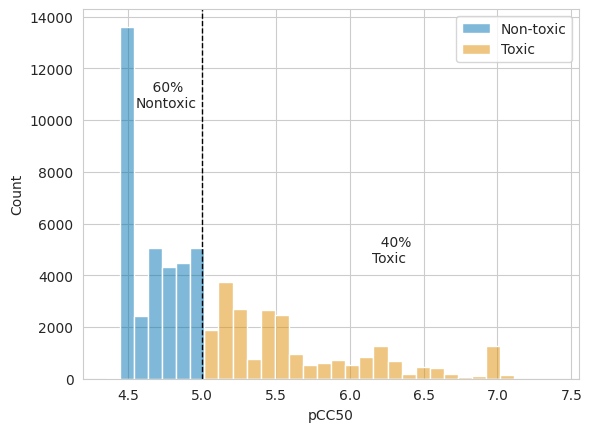

In [16]:
sns.set_style('whitegrid')
g = sns.histplot(data=hepg2_df, x='pCC50', hue='tox_class', bins=32,
             palette=sns.color_palette('colorblind'))
g.legend_.set_title(None)
plt.axvline(5, c='k', ls='--', lw=1)
g.text(4.55, 10500, '    {0:.0%}\nNontoxic'.format(nontox_frac))
g.text(6.15, 4500, '  {0:.0%}\nToxic'.format(tox_frac))

# **Add calculated properties to dataframes**

In [17]:
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')

[04:27:25] WARNING: not removing hydrogen atom without neighbors


In [18]:
PandasTools.AddMoleculeColumnToFrame(hepg2_df, 'smiles', 'Molecule')

[04:27:28] WARNING: not removing hydrogen atom without neighbors


In [19]:
add_props_to_df(train_df, 'Molecule')

[04:27:38] WARNING: not removing hydrogen atom without neighbors


In [20]:
add_props_to_df(hepg2_df,'Molecule')

[04:29:12] WARNING: not removing hydrogen atom without neighbors


## **Create histograms for all properties using Tox21 training set**

<Figure size 640x480 with 0 Axes>

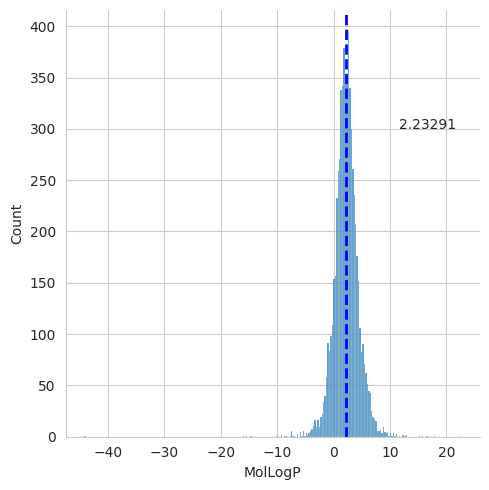

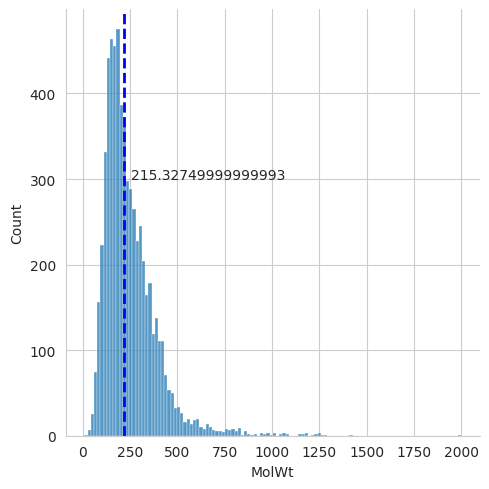

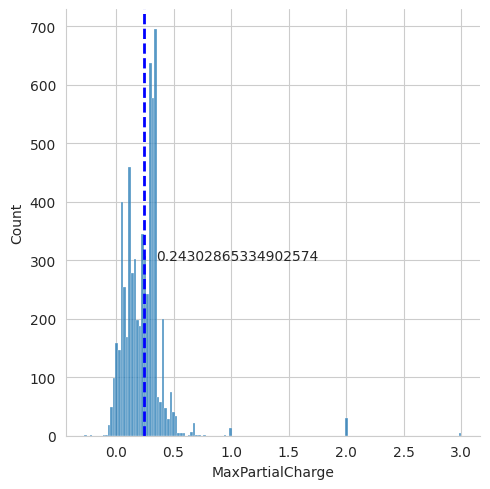

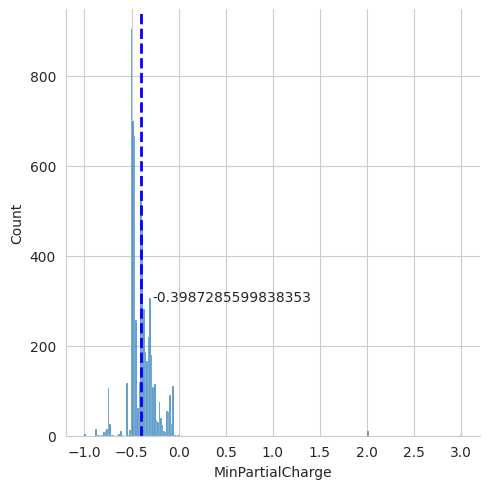

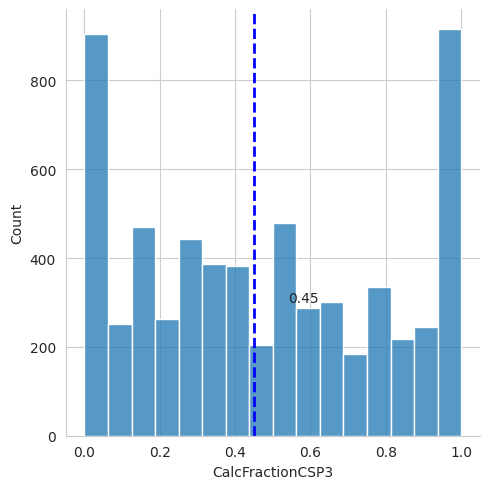

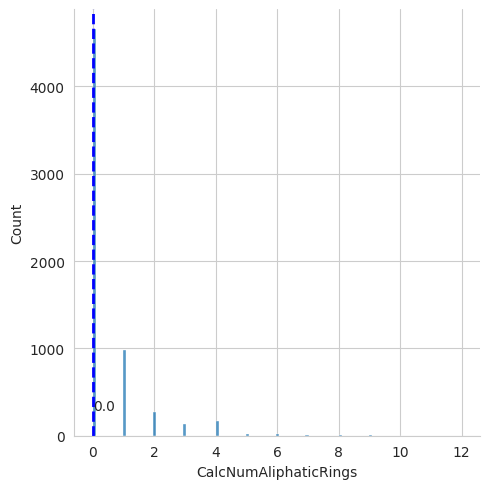

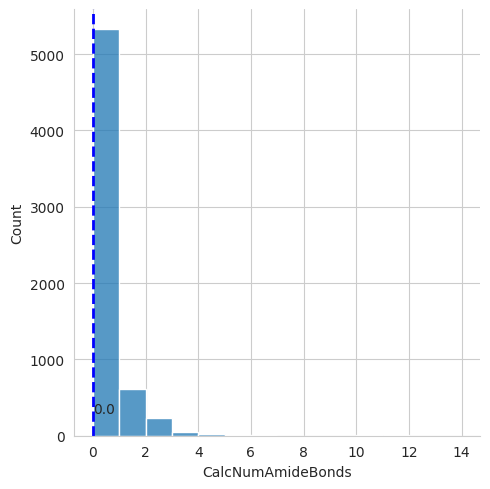

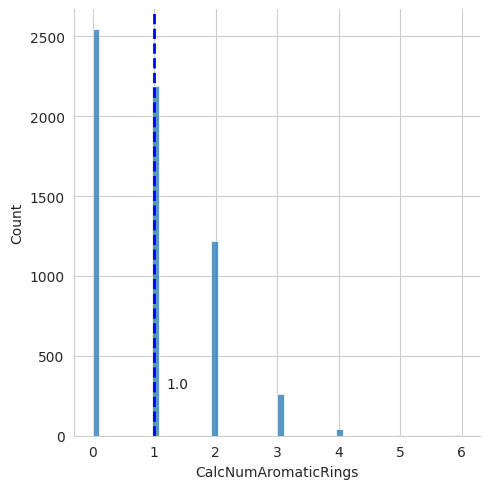

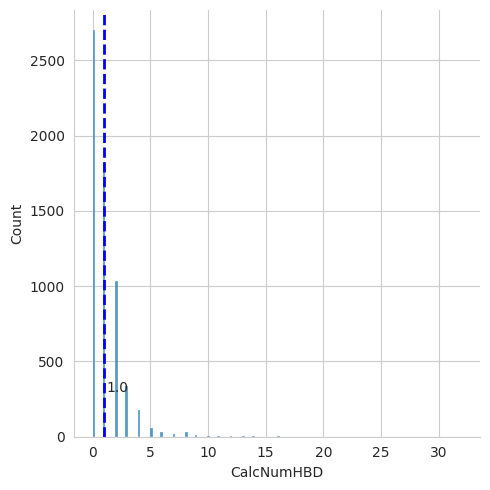

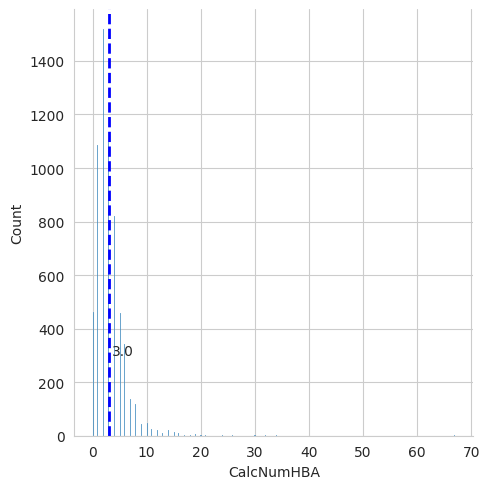

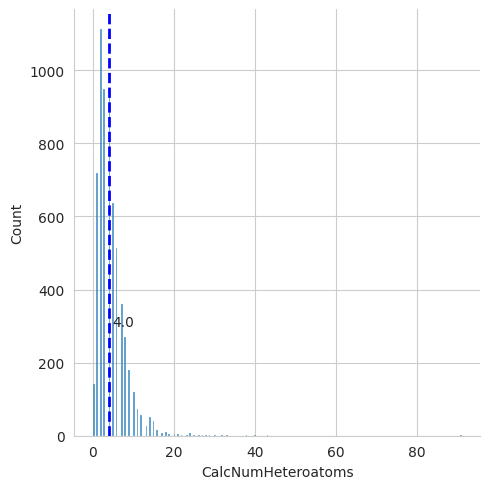

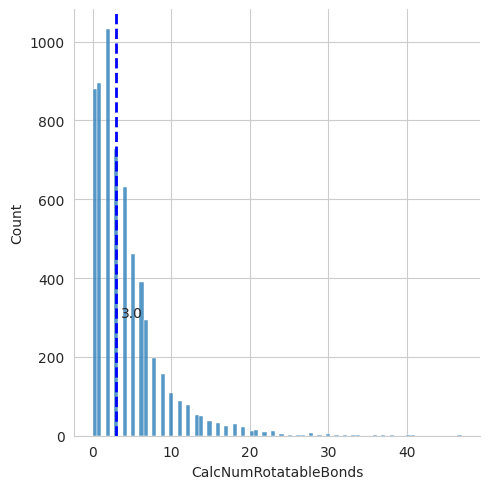

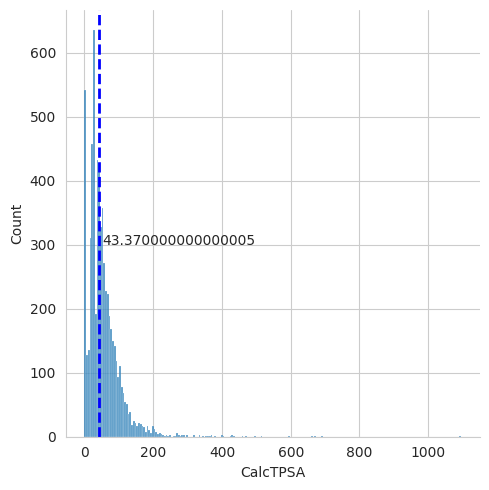

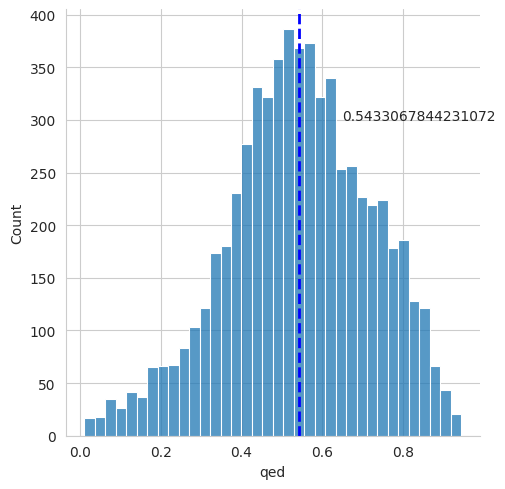

In [21]:
plot_prop_dists(train_df)

## **Create histograms for all properties using HepG2 dataset**

<Figure size 640x480 with 0 Axes>

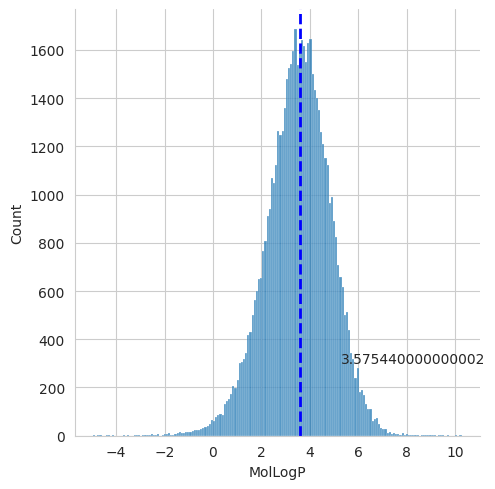

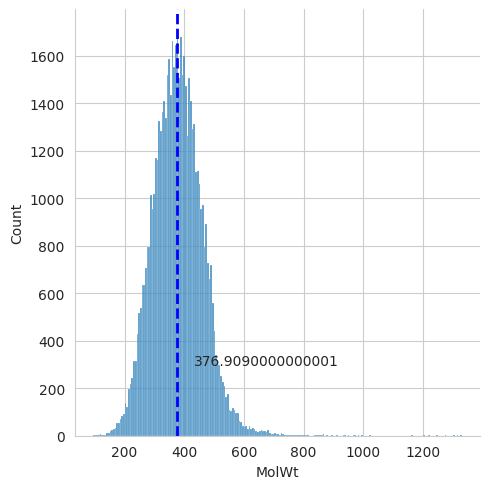

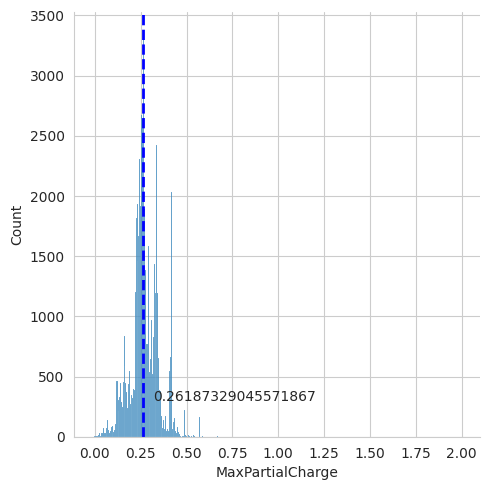

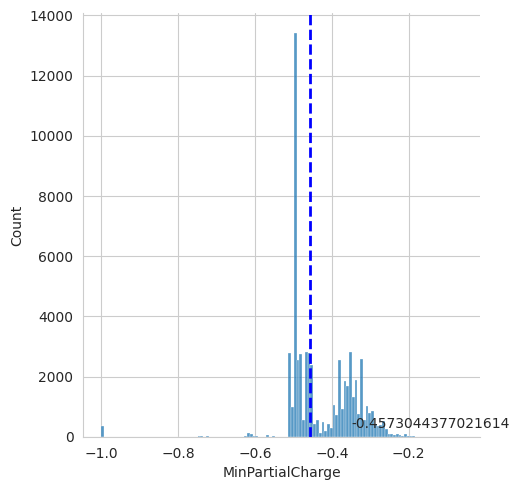

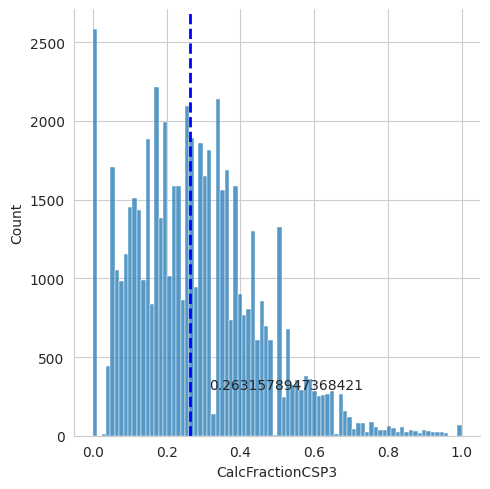

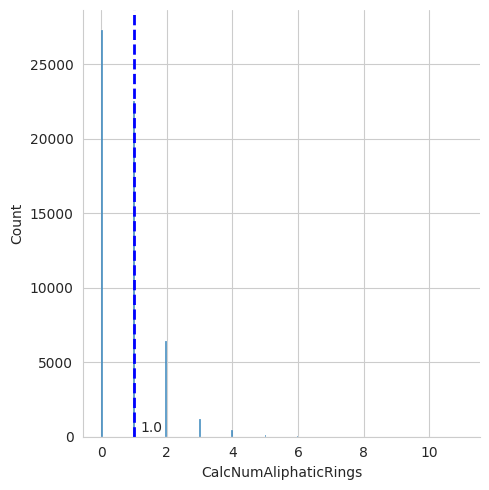

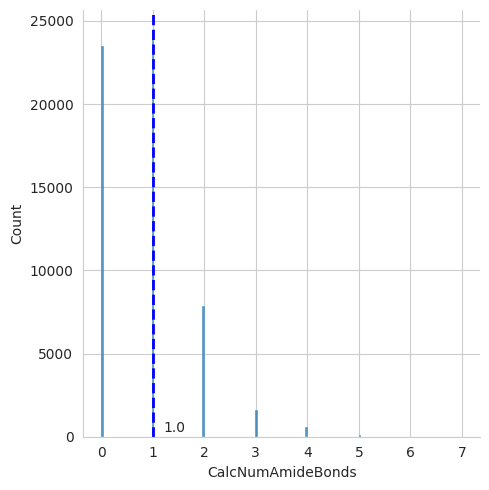

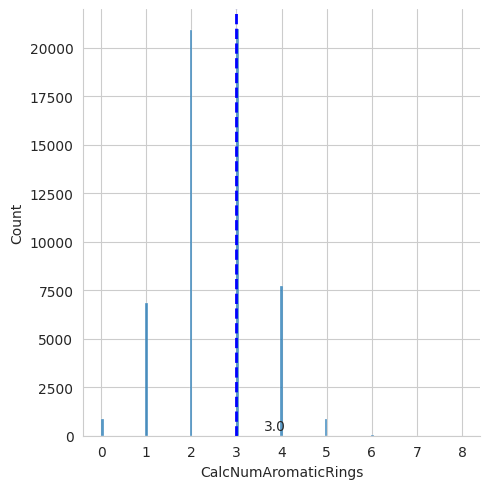

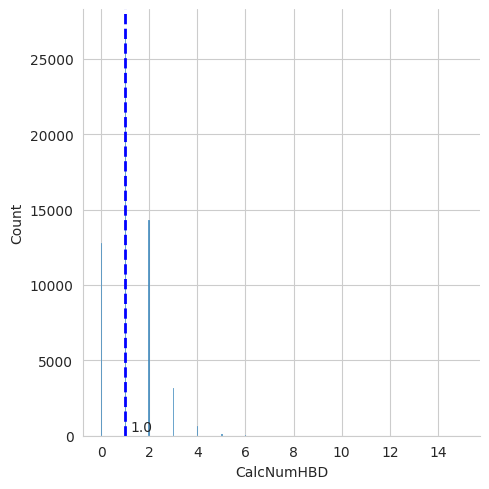

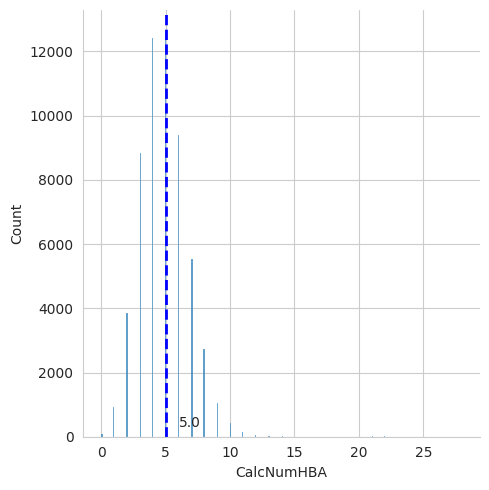

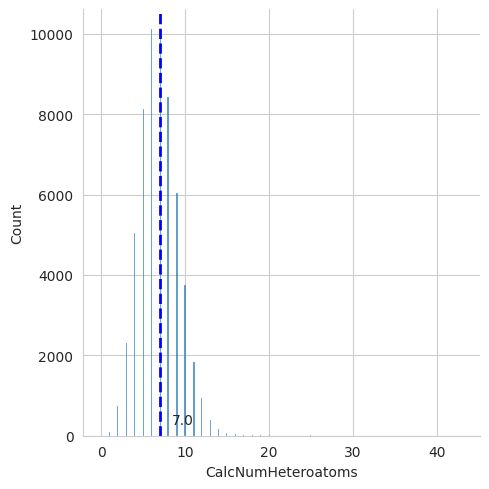

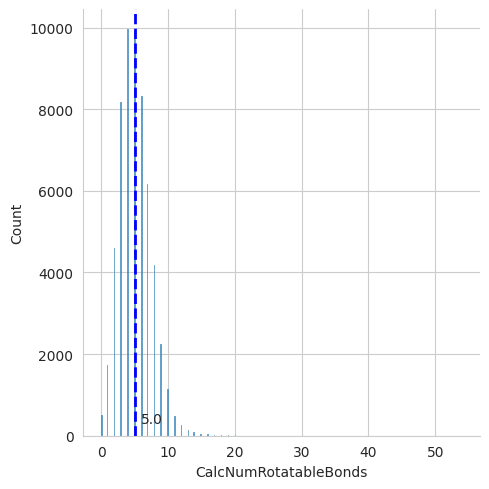

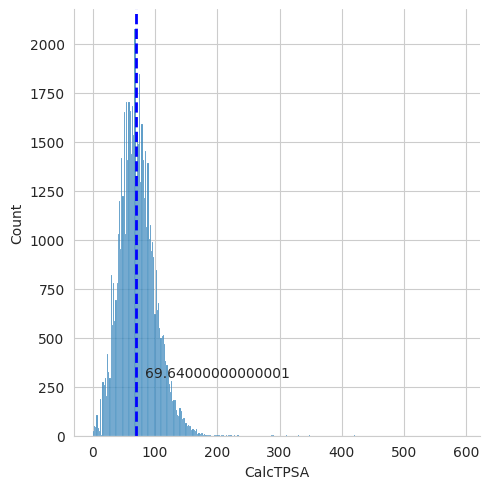

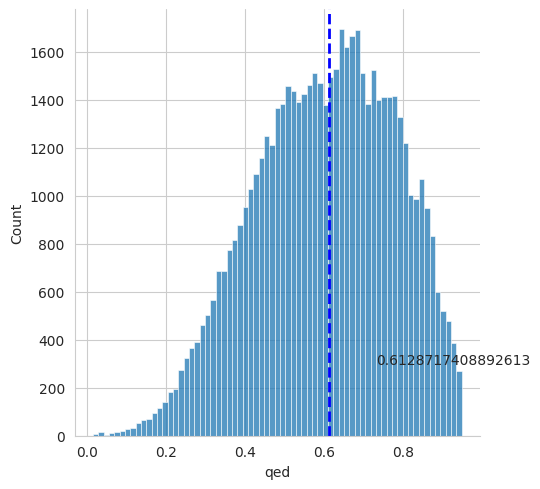

In [22]:
plot_prop_dists(hepg2_df)

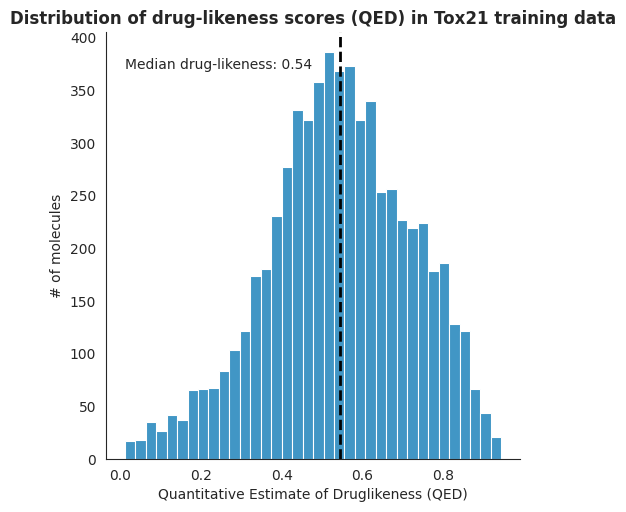

In [23]:
sns.set_style('white')
ax = sns.displot(data=train_df, x='qed', color=sns.color_palette('colorblind')[0])
ax.set(xlabel='Quantitative Estimate of Druglikeness (QED)', 
       ylabel='# of molecules')
plt.title('Distribution of drug-likeness scores (QED) in Tox21 training data', weight='bold')
median_qed = train_df['qed'].median()
plt.axvline(x=median_qed, color="black", ls="--",lw=2)
plt.text(0.01, 370, 'Median drug-likeness: ' + f'{median_qed:2.2f}')
sns.despine()

Generate final side-by-side plots

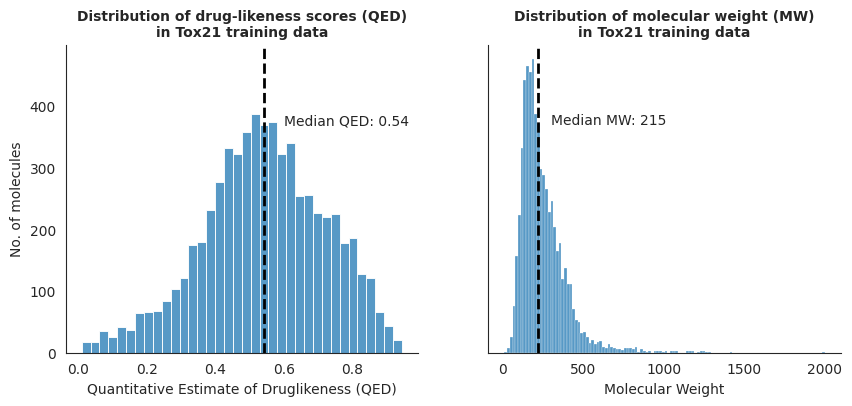

In [24]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,4))
sns.histplot(data=train_df, x='qed', ax=ax1)
#fig.suptitle('Distribution of drug-likeness scores (left) and molecular weight (right) in Tox21 training data', weight='bold', fontsize=11)
ax1.set_title('Distribution of drug-likeness scores (QED)\nin Tox21 training data', weight='bold', fontsize=10)
ax1.set(xlabel='Quantitative Estimate of Druglikeness (QED)', 
       ylabel='No. of molecules')
median_qed = train_df['qed'].median()
ax1.axvline(x=median_qed, color="black", ls="--",lw=2)
ax1.text(0.6, 370, 'Median QED: ' + f'{median_qed:2.2f}')
sns.histplot(data=train_df, x='MolWt', ax=ax2)
ax2.set_title('Distribution of molecular weight (MW)\nin Tox21 training data', weight='bold', fontsize=10)
ax2.set(xlabel='Molecular Weight', 
       ylabel='# of molecules')
median_mw = train_df['MolWt'].median()
ax2.axvline(x=median_mw, color="black", ls="--",lw=2)
ax2.text(300, 370, 'Median MW: ' + f'{median_mw:2.0f}')
sns.despine()